In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog

from tqdm import tqdm

from sklearn.externals import joblib
import imageio
imageio.plugins.ffmpeg.download()

from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque
from scipy.ndimage.measurements import label

import utils

## Loading the classifier data

In [2]:
# Load the classifier
data_file = 'classifier_data.p'
with open(data_file, mode='rb') as f:
    data = pickle.load(f)
    
svc = data['svc'] 
X_scaler = data['X_scaler']
color_space = data['color_space']
spatial_size = data['spatial_size']
hist_bins = data['hist_bins']
orient = data['orient']
pix_per_cell = data['pix_per_cell']
cell_per_block = data ['cell_per_block']
hog_channel = data['hog_channel']
spatial_features = data ['spatial_features']
hist_features = data['hist_features']
hog_features = data['hog_features']

print('Classifier Loaded')

Classifier Loaded


In [3]:
#helper for plotting imgs
def plot_imgs(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])
    plt.show()

### Find Cars in test img

In [4]:
test_imgs = 'test_images/*'
test_imgs_list = glob.glob(test_imgs)

images = []
titles = []
y_start_stop = [370, 656] # Min & Max in y to search in slide_window()
overlap = 0.70
xy_window = 80

for raw_img in tqdm(test_imgs_list):
    t1 = time.time()
    img = mpimg.imread(raw_img)
    img_copy = np.copy(img)
    img = img.astype(np.float32)/255
        
    windows =  utils.slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop,
                               xy_window=(xy_window, xy_window), xy_overlap=(overlap, overlap))
    
    hot_windows = utils.search_windows(img, windows, svc, X_scaler, color_space=color_space,
                             spatial_size=spatial_size, hist_bins=hist_bins,
                             orient=orient, pix_per_cell=pix_per_cell,
                             cell_per_block=cell_per_block,
                             hog_channel=hog_channel, spatial_feat=spatial_features,
                             hist_feat=hist_features, hog_feat=hog_features)
        
    window_img = utils.draw_boxes(img_copy, hot_windows, color=(0, 0 ,255), thick=6)
    images.append(window_img)
    titles.append('')

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:10<00:00,  1.74s/it]


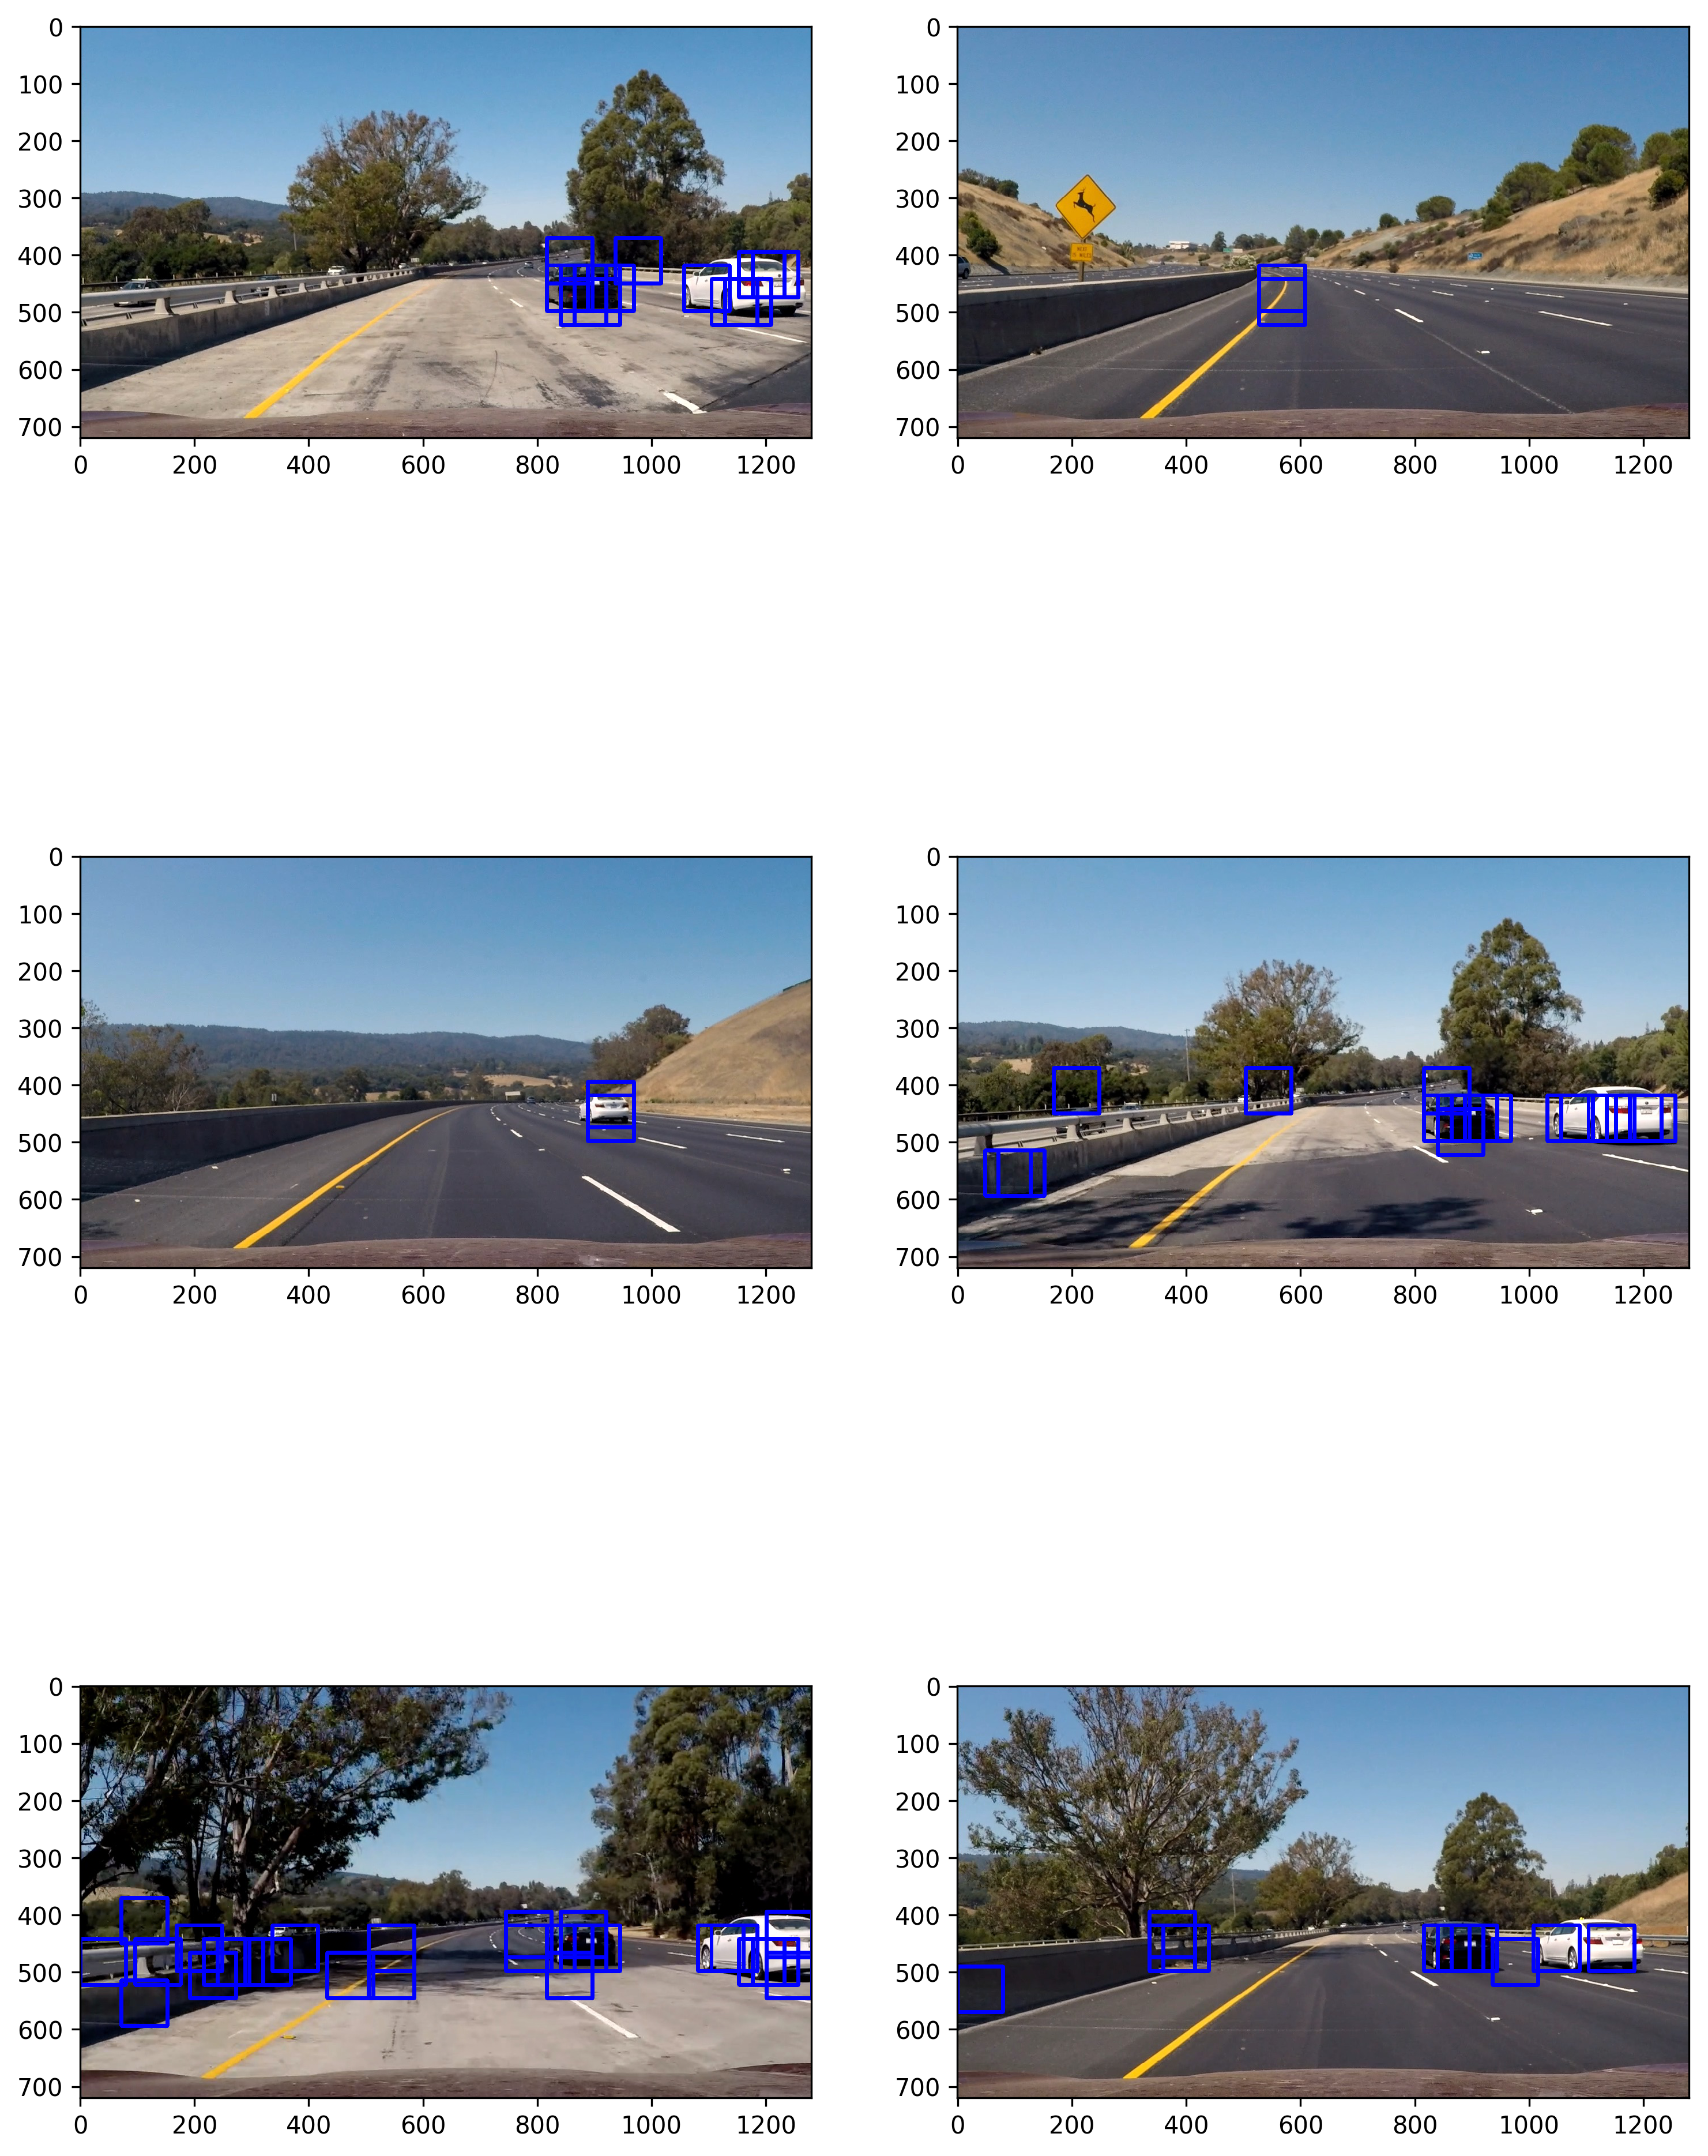

In [5]:
fig = plt.figure(figsize=(12,18), dpi=300)
plot_imgs(fig,3,2,images,titles)

## Searching test imgs

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:10<00:00,  1.81s/it]


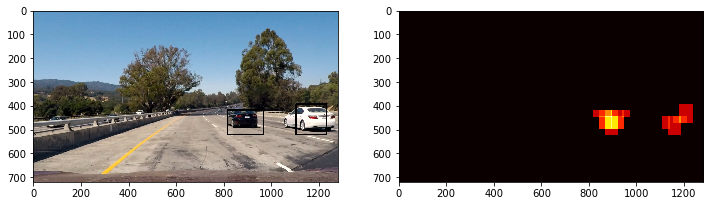

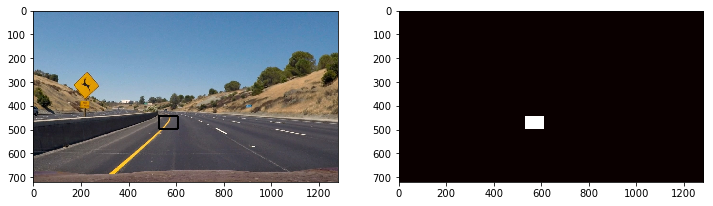

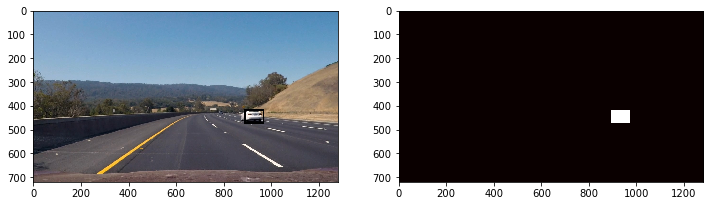

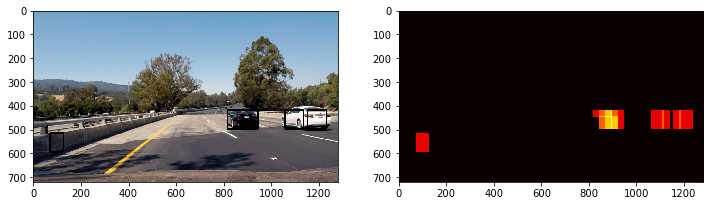

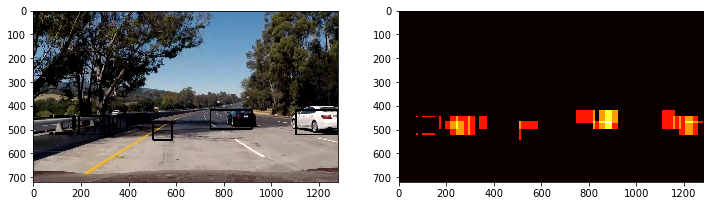

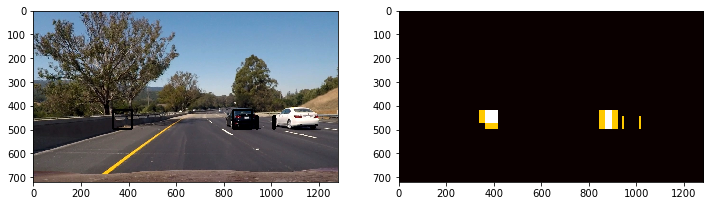

In [6]:
for raw_img in tqdm(test_imgs_list):
    t1 = time.time()
    img = mpimg.imread(raw_img)
    img_copy = np.copy(img)
    img = img.astype(np.float32)/255
        
    windows =  utils.slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop,
                               xy_window=(xy_window, xy_window), xy_overlap=(overlap, overlap))
    
    hot_windows = utils.search_windows(img, windows, svc, X_scaler, color_space=color_space,
                             spatial_size=spatial_size, hist_bins=hist_bins,
                             orient=orient, pix_per_cell=pix_per_cell,
                             cell_per_block=cell_per_block,
                             hog_channel=hog_channel, spatial_feat=spatial_features,
                             hist_feat=hist_features, hog_feat=hog_features)
    
    heat_map = np.zeros_like(img[:,:,0]).astype(np.float)
    heatmap = utils.add_heat(heat_map, hot_windows)
    heatmap = utils.apply_threshold(heatmap, 1)
    heatmap = np.clip(heatmap, 0 , 255)
    labels = label(heatmap)
    #Draw bounding boxes on a copy of the image
    draw_img = utils.draw_labeled_bboxes(np.copy(img), labels)
    
#     hot_windows = utils.search_windows(img, windows, svc, X_scaler, color_space=color_space,
#                              spatial_size=spatial_size, hist_bins=hist_bins,
#                              orient=orient, pix_per_cell=pix_per_cell,
#                              cell_per_block=cell_per_block,
#                              hog_channel=hog_channel, spatial_feat=spatial_features,
#                              hist_feat=hist_features, hog_feat=hog_features)
        
#     window_img = utils.draw_boxes(img_copy, hot_windows, color=(0, 0 ,255), thick=6)
#     images.append(window_img)
#     titles.append('')
    
    images.append(window_img)
    titles.append('')

    plt.figure(figsize=(12,18))
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.subplot(122)
    plt.imshow(heat_map, cmap='hot')
    
plt.show()

## Save the video

In [7]:
from collections import deque
b_boxes_deque = deque(maxlen=30)

def add_heat_video(heatmap, b_boxes_deque):
    # Iterate through list of bboxes
    for bbox_list in b_boxes_deque:
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap

def process_image(img):
    
    img_copy = np.copy(img)
    img = img.astype(np.float32)/255
        
    windows =  utils.slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop,
                               xy_window=(xy_window, xy_window), xy_overlap=(overlap, overlap))
    
    hot_windows = utils.search_windows(img, windows, svc, X_scaler, color_space=color_space,
                             spatial_size=spatial_size, hist_bins=hist_bins,
                             orient=orient, pix_per_cell=pix_per_cell,
                             cell_per_block=cell_per_block,
                             hog_channel=hog_channel, spatial_feat=spatial_features,
                             hist_feat=hist_features, hog_feat=hog_features)
    
    b_boxes_deque.append(hot_windows)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    add_heat_video(heat, b_boxes_deque)

    # Apply threshold to remove false positive and ensure only recurring cars in the frame are detected
    heat = utils.apply_threshold(heat,22)

    heatmap = np.clip(heat, 0, 255)

    labels = label(heatmap)
    draw_img = utils.draw_labeled_bboxes(img_copy, labels)

    return draw_img

In [10]:
# Import stuff needed for video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

proj_output = 'project_video_output.mp4'
clip = VideoFileClip("project_video.mp4")
output_clip = clip.fl_image(process_image)
output_clip.write_videofile(proj_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [37:57<00:01,  1.78s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

